# PERSIANN - Precipitation Data
 - **@author**: Mario Garcia (mario.garcia@utec.edu.uy)
 - **@description**: Procesamiento de los datos RAW de las estimaciones de precipitacion del producto satelital.  
 - **Data Source**:  https://chrsdata.eng.uci.edu/
 - **Output**: 
  - **persiann_daily_2000_2020.nc** (Dataset netCDF unificado de las celdas persiann con los geodatos de latitud y longitud)
  - mater_persiann_daily_2000_2020.nc (Dataset netCDF persiann_daily_2000_2020.nc que ha pasado control de calidad y puede ser utilizado para la próxima etapa)

 - **Input**: 
   -  https://chrsdata.eng.uci.edu/userFile/PERSIANN-PDIR/mario.garcia9O3kDf.zip (netCDF con datos raw de las estimaciones de precipitacion del producto satelital). Se puede usar tambien master_data_raw_persiann.zip 
 - **@version**: v1.3
 - **@date**: 2022-08-10,  2022-08-06, 2022-08-01, 2022-07-30, 2022-07-26   


## Setup

In [1]:
dir_google_drive = "/content/drive/MyDrive/ValidacionProductosSatelitales(VPS)/Proyecto Colab/03 - DataLake/"
dir_data = './data/'
dir_data_source = dir_data+'/source/'
dir_var = './var/'
dir_download = dir_var+'/download/'
dir_output = dir_var+'/output/'
dir_log = dir_var+'/log/'


### Libraries

In [2]:
!pip install geopandas 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.9 MB/s 
     |████████████████████████████████| 16.7 MB 400 kB/s 
     |████████████████████████████████| 6.3 MB 47.0 MB/s 


In [3]:
# Data
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Utils
import os 
# import shutil
import glob

# Zip
import zipfile

# NetCDF
import xarray  as xr

# GEO MAPS
# https://jcutrer.com/python/learn-geopandas-plotting-usmaps
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [4]:
def get_geometry_uruguay():
  df_world_shapes = gpd.read_file(dir_data+"/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp")
  df_uruguay_shapes = df_world_shapes[ df_world_shapes['ISO2'] == 'UY']
  # df_uruguay_shapes
  polygon_uruguay = df_uruguay_shapes['geometry']
  return polygon_uruguay
  # polygon_uruguay = geometry[210]
  # return gpd.GeoSeries(polygon_uruguay)

### Init

In [5]:
!rm -rf "$dir_data"

!mkdir -p "$dir_data"
!mkdir -p "$dir_data_source"
!mkdir -p "$dir_download"
!mkdir -p "$dir_output"
!mkdir -p "$dir_log"

!mkdir -p "$dir_data"/TM_WORLD_BORDERS
!wget  -O "$dir_download"/TM_WORLD_BORDERS-0.3.zip  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip 
!unzip -o "$dir_download"/TM_WORLD_BORDERS-0.3.zip -d "$dir_data"/TM_WORLD_BORDERS 


--2022-08-10 18:22:28--  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip
Resolving thematicmapping.org (thematicmapping.org)... 67.20.120.230
Connecting to thematicmapping.org (thematicmapping.org)|67.20.120.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3464707 (3.3M) [application/zip]
Saving to: ‘./var//download//TM_WORLD_BORDERS-0.3.zip’

./var//download//TM 100%[===================>]   3.30M  10.7MB/s    in 0.3s    

2022-08-10 18:22:28 (10.7 MB/s) - ‘./var//download//TM_WORLD_BORDERS-0.3.zip’ saved [3464707/3464707]

Archive:  ./var//download//TM_WORLD_BORDERS-0.3.zip
  inflating: ./data//TM_WORLD_BORDERS/Readme.txt  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.dbf  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.prj  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shx  


## Download Data

In [6]:
url="https://chrsdata.eng.uci.edu/userFile/PERSIANN-PDIR/mario.garcia9O3kDf.zip"# <--- paste it, here your url
filename = dir_download+"/satellite_data.zip"
!wget  -O  "$filename" "$url"

--2022-08-10 18:22:28--  https://chrsdata.eng.uci.edu/userFile/PERSIANN-PDIR/mario.garcia9O3kDf.zip
Resolving chrsdata.eng.uci.edu (chrsdata.eng.uci.edu)... 128.200.71.193
Connecting to chrsdata.eng.uci.edu (chrsdata.eng.uci.edu)|128.200.71.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23426149 (22M) [application/zip]
Saving to: ‘./var//download//satellite_data.zip’

./var//download//sa 100%[===================>]  22.34M  55.0MB/s    in 0.4s    

2022-08-10 18:22:29 (55.0 MB/s) - ‘./var//download//satellite_data.zip’ saved [23426149/23426149]



In [ ]:
# unzip data
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(dir_data_source)

## Config

In [ ]:
var_lat = 'lat'
var_lon = 'lon'
var_time = 'datetime'
var_precipitation = 'precip'

var_null_values = -598

var_null_values_from_source = -99.0

## Process Data

In [ ]:
pattern = dir_data_source+'/*.nc'
ds_xr_multi = xr.open_mfdataset(pattern,chunks={var_lat: 100, var_lon: 100,var_time: '1GB'})
ds_xr_multi

<xarray.Dataset>
Dimensions:   (lon: 135, lat: 124, datetime: 7611)
Coordinates:
  * lon       (lon) float32 -58.44 -58.4 -58.36 -58.32 ... -53.16 -53.12 -53.08
  * lat       (lat) float32 -30.04 -30.08 -30.12 -30.16 ... -34.88 -34.92 -34.96
  * datetime  (datetime) datetime64[ns] 2000-03-01 2000-03-02 ... 2020-12-31
Data variables:
    crs       (datetime) int32 -2147483647 -2147483647 ... -2147483647
    precip    (datetime, lat, lon) int16 dask.array<chunksize=(306, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6

In [ ]:
ds_xr_multi[var_precipitation].data

dask.array<concatenate, shape=(7611, 124, 135), dtype=int16, chunksize=(366, 100, 100), chunktype=numpy.ndarray>

### Standarize

In [ ]:
# !apt-get -y install netcdf-bin
# !ncdump -h /content/data/source/CDR_Uruguay_2022-07-27102443pm_2001.nc

In [ ]:
names = {var_time:'time', var_precipitation:'precipitation', var_lat:'lat', var_lon:'lon'}
ds_xr_multi = ds_xr_multi.rename(names)
ds_xr_multi

<xarray.Dataset>
Dimensions:        (lon: 135, lat: 124, time: 7611)
Coordinates:
  * lon            (lon) float32 -58.44 -58.4 -58.36 ... -53.16 -53.12 -53.08
  * lat            (lat) float32 -30.04 -30.08 -30.12 ... -34.88 -34.92 -34.96
  * time           (time) datetime64[ns] 2000-03-01 2000-03-02 ... 2020-12-31
Data variables:
    crs            (time) int32 -2147483647 -2147483647 ... -2147483647
    precipitation  (time, lat, lon) int16 dask.array<chunksize=(306, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6

In [ ]:
ds_xr_multi = ds_xr_multi[['precipitation']]
ds_xr_multi

<xarray.Dataset>
Dimensions:        (time: 7611, lat: 124, lon: 135)
Coordinates:
  * lon            (lon) float32 -58.44 -58.4 -58.36 ... -53.16 -53.12 -53.08
  * lat            (lat) float32 -30.04 -30.08 -30.12 ... -34.88 -34.92 -34.96
  * time           (time) datetime64[ns] 2000-03-01 2000-03-02 ... 2020-12-31
Data variables:
    precipitation  (time, lat, lon) int16 dask.array<chunksize=(306, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6

In [ ]:
ds_xr_multi['precipitation'] = ds_xr_multi['precipitation'].astype(np.float32)
ds_xr_multi['lat'] = ds_xr_multi['lat'].astype(np.float32)
ds_xr_multi['lon'] = ds_xr_multi['lon'].astype(np.float32)
ds_xr_multi

<xarray.Dataset>
Dimensions:        (time: 7611, lat: 124, lon: 135)
Coordinates:
  * lon            (lon) float32 -58.44 -58.4 -58.36 ... -53.16 -53.12 -53.08
  * lat            (lat) float32 -30.04 -30.08 -30.12 ... -34.88 -34.92 -34.96
  * time           (time) datetime64[ns] 2000-03-01 2000-03-02 ... 2020-12-31
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(306, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6

### Filtre

In [ ]:
# replace all missing values with -999
mask = (ds_xr_multi['precipitation'] == var_null_values_from_source)
ds_xr_multi['precipitation'] = xr.where(mask, var_null_values, ds_xr_multi['precipitation'])
ds_xr_multi_query = ds_xr_multi

In [ ]:
# Uruguay box
lat_max = -30; lat_min = -35
lon_max = -53; lon_min = -59

ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lat'] < lat_max, drop=True)
ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lat'] > lat_min, drop=True)

ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lon'] < lon_max, drop=True)
ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lon'] > lon_min, drop=True)

In [ ]:
ds_xr_multi_query_done = ds_xr_multi_query.compute()
ds_xr_multi_query_done

<xarray.Dataset>
Dimensions:        (time: 7611, lat: 124, lon: 135)
Coordinates:
  * lon            (lon) float32 -58.44 -58.4 -58.36 ... -53.16 -53.12 -53.08
  * lat            (lat) float32 -30.04 -30.08 -30.12 ... -34.88 -34.92 -34.96
  * time           (time) datetime64[ns] 2000-03-01 2000-03-02 ... 2020-12-31
Data variables:
    precipitation  (time, lat, lon) float32 -598.0 -598.0 ... -598.0 -598.0
Attributes:
    Conventions:  CF-1.6

## Export

In [ ]:
encoding = {'precipitation': {
                  #'_FillValue': var_null_values,      NOT SUPPORTED by xArray
                  #'missing_value': var_null_values,   NOT SUPPORTED by xArray
                  # 'chunksizes': (1, 8, 10),
                  'complevel': 9,
                  'zlib': True}
            }            
file_nc = dir_output+'/persiann_daily_2000_2020.nc'
ds_xr_multi_query_done.to_netcdf(file_nc,mode="w", encoding=encoding)

In [ ]:
# Export to drive (optional)
!cp "$file_nc" "$dir_google_drive" 

## Plot

In [ ]:
file_nc = dir_google_drive+'/persiann_daily_2000_2020.nc'

df_xr_raw = xr.open_dataset(file_nc) # !Important for Null Values
# !Important
mask = df_xr_raw.precipitation > 0
df_xr = df_xr_raw.where( mask )

# df_xr = xr.open_dataset(file_nc, mask_and_scale=True) # !Important for Null Values -598
# df_xr

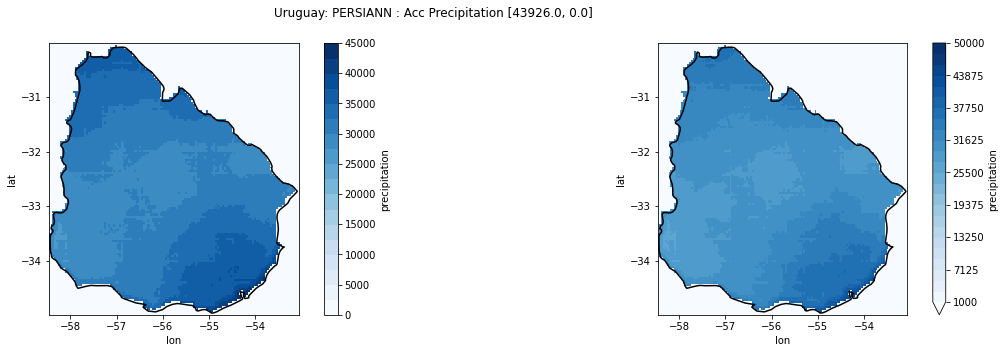

In [ ]:
# coordinate reference system
crs={'init':'epsg:4326'}

geodf_shape = get_geometry_uruguay()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))  

df_xr_acc = df_xr.sum(dim="time")['precipitation']


df_xr_acc.plot(ax=axs[0], x="lon", y="lat", cmap="Blues", levels=20)
geodf_shape.boundary.plot(ax=axs[0], color="black")

df_xr_acc.plot(ax=axs[1], x="lon", y="lat", cmap="Blues", levels=np.linspace(1000, 50000, 25))
geodf_shape.boundary.plot(ax=axs[1], color="black")

prec_max = np.round(float(df_xr_acc.max().data), 2)
prec_min = np.round(float(df_xr_acc.min().data), 2)
fig.suptitle(f'Uruguay: PERSIANN : Acc Precipitation [{prec_max}, {prec_min}]', fontsize=12)
plt.show()